Задача: Нечистое на руку казино  
Студент: Головкин М.А. МСКМ-191  

В казино почти всегда используется правильная игральная кость, но иногда ее подменяют неправильной. Неправильная кость имеет вероятность 0.5 выпадения шестерки и вероятность 0.1 выпадения остальных чисеел от 1 до 5. Предположим, что казино подменяет правильную кость неправильной с вероятностью 0.05 перед каждым броском, а вероятность обратной подмены равна 0.1.

In [1]:
# Используемые библиотеки
import numpy as np
import matplotlib.pyplot as plt
plt.rc('font', family='Verdana')
import copy
import time
from IPython.display import Image 
%matplotlib inline

Общие функции, используемые для реализации алгоритмов.

In [2]:
# Функция расчета предельного (стационарного) распределения квадратной матрицы А
# Входной параметр: квадратная матрица 
# Выходной параметр: массив предельного (стационарного) распределения
def stationary_distribution(A):
    n = len(A)
    M1 = np.vstack(((A.transpose() - np.eye(n))[:-1],np.ones(n)))
    v1 = np.eye(n)[-1]
    p = np.linalg.solve(M1,v1)
    return p

# Функция перевода из номеров в обозначения F и L
# Входной параметр: массив из 0 и 1, обозначающий состояния
# Выходной параметр: строка из F и L, обозначающая состояния
def translation(l):
    L = len(l)
    c = ''
    dec = {0:'F', 1:'L'}
    for i in range(L):
        c += dec[l[i]]
    return c

# Фукнция создания вектора наблюдений x и вектора действительных состояний l 
# Входные параметры: матрица переходных вероятностей, матрица эмиссий, длина последовательности 
# Выходной параметр: массивы действителььных состояний и наблюдений
def Observation(A, E, L):
    M = len(E)
    R = len(E.transpose())
    x = np.zeros((L,), dtype=int)
    l = np.zeros((L,), dtype=int)
    stat_dist = stationary_distribution(A)
    r1 = np.random.random()
    flag1 = 0 
    for i in range(M):
        if r1 < (flag1 + stat_dist[i]):
            l[0] = i
            r2 = np.random.random()
            flag2 = 0
            for j in range(R):
                if r2 < (flag2 + E[i,j]):
                    x[0] = j+1
                    break;
                flag2 += E[i,j]
            break;
        flag1 += stat_dist[i]
    for k in range(1,L):
        r1 = np.random.random()
        flag1 = 0
        for i in range(M):
            if r1 < (flag1 + A[l[k-1],i]):
                l[k] = i
                r2 = np.random.random()
                flag2 = 0
                for j in range(R):
                    if r2 < (flag2 + E[i,j]):
                        x[k] = j+1
                        break;
                    flag2 += E[i,j]
                break;
            flag1 += A[l[k-1],i]
    return l, x


**АЛГОРИТМ ВИТЕРБИ**

Функции, необходимые для реализации алгоритма Витерби

In [3]:
# Алгоритм Витерби для поиска наиболее вероятного пути
# Входные параметры: матрица переходных вероятностей, матрица эмиссий, длина последовательности 
# Выходной параметр: массив наиболее вероятных состояний
def Algorithm_Viterby(Rolls, A, E):
    L = len(Rolls)
    M = len(E)
    V = np.zeros((M, L))
    Ptr = np.zeros((M, L))
    m = np.zeros(L)
    V[:, 0] = stationary_distribution(A)*E[:, Rolls[0] - 1]
    m[0] = max(V[:, 0])
    V[:, 0] /= m[0]
    for i in range(1, L):
        for j in range(M):
            S = E[j, Rolls[i]-1]*V[:, i-1]*A[:, j]
            V[j,i] = max(S)
            Ptr[j,i] = np.argmax(S)
    P = np.zeros(L)
    P[-1] = np.argmax(V[:,-1])
    for i in range(L-2,-1,-1):
        P[i] = Ptr[int(P[i+1]),i+1]
    Real = translation(P)
    return Real

# Функция печати наблюдений и состояний для алгоритма Витерби
# Входные параметры: массивы действительных состояний и наблюдений, массив наиболее вероятных наблюдений, ширина выводных строк
# Выходной параметр: выведенные на экран входные массивы, частота верно определенных состояний
def print_model_Viterby(Die, Rolls, Viterby, d):
    L = len(Rolls)
    Die = translation(Die)
    for j in range (L//d):
        print('Rolls:   ', end = '')
        for i in range(d*j, d*(j+1)):
            print(Rolls[i], end = '')
        print('\nDie:     ', end = '')
        print(''.join(Die[d*j:d*(j+1)]))
        print('Viterby: ', end = '')
        print(''.join(Viterby[d*j:d*(j+1)]),'\n')
    if (L % d) !=0:
        print('Rolls:   ', end = '')
        for i in range(L-L % d, L):
            print(Rolls[i], end = '')
        print('\nDie:     ', end = '')
        print(''.join(Die[L-L % d:]))
        print('Viterby: ', end = '')
        print(''.join(Viterby[L-L % d:]))
    s = 0
    for i in range(L):
        if Die[i] == Viterby[i]:
            s+=1
    print('\nЧастота совпадения:', s/L)

Переменные, необходимые для реализации алгоритма Витерби.  
А - матрица переходных вероятностей  
E - матрица эмиссий  

In [4]:
A = np.array([[0.95,0.05],[0.1,0.9]])
E = np.array([[1/6,1/6,1/6,1/6,1/6,1/6],[0.1,0.1,0.1,0.1,0.1,0.5]])
print('A:', A, 'E:', E, sep = '\n')

A:
[[ 0.95  0.05]
 [ 0.1   0.9 ]]
E:
[[ 0.16666667  0.16666667  0.16666667  0.16666667  0.16666667  0.16666667]
 [ 0.1         0.1         0.1         0.1         0.1         0.5       ]]


Изображение результатов алгоритма Витерби для последовательности длиной 300  
L - длина последовательности  
Rolls - массив наблюдений  
Die - массив действительных состояний  
Viterby - наиболее вероятный массив состояний  

In [5]:
L = 300
Die, Rolls = Observation(A, E, L)
Viterby = Algorithm_Viterby(Rolls, A, E)
print_model_Viterby(Die, Rolls, Viterby, 110)

Rolls:   66666611662655566315432131433412124453511514613354666661416641662431245116626321266462255435123625164131645313
Die:     LLLLLLLLLLLLLLLLLLLLLLLFFFFFFFFFFFFFFFFLLFFFFFFFFFLLLLLLFFLFFFFFFFFFFFFFFFFFFFFFFFFFFFLLFFLFFFFFFFFFFFFFFFFFFF
Viterby: LLLLLLLLLLLLLLLLLFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFLLLLLLLLLLLLLLFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF 

Rolls:   34344224533532632661535341625216421152244463514212665466323346661146356345156256431322142121125613151662414363
Die:     FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFLLLLLLLLFFLLLLFFFFFFFFFFFFFFFFFLLLLFFFFFFFFFLLLLLLLLLFFFFFFF
Viterby: FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF 

Rolls:   65535654533541665226246426625243162643225525431564611261341236332645136451625264
Die:     FFFFFFFFFFFFFFFLLLLLLLLLLLLFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF
Viterby: FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF

Часто

Изображение результатов алгоритма Витерби для последовательности длиной 1000  
L - длина последовательности  
Rolls - массив наблюдений  
Die - массив действительных состояний  
Viterby - наиболее вероятный массив состояний  

In [6]:
L = 1000
Die, Rolls = Observation(A, E, L)
Viterby = Algorithm_Viterby(Rolls, A, E)
print_model_Viterby(Die, Rolls, Viterby, 110)

Rolls:   66616426626661523313362416434451134223133245356623342336331243342346431433126666636661314126546316314556544364
Die:     LLLLLLLLLLLLLLFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFLFFFFFFFFFFFFFFFFFFFFFFFFFFLLLLLLFFFFFLLLFFFFFFFFFFFFFFFFFLFFFF
Viterby: LLLLLLLLLLLLLFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFLLLLLLLLLFFFFFFFFFFFFFFFFFFFFFFFFF 

Rolls:   12446524254551515324344255222162642565232264211621113255644216166113535316625634154213652654326324441314666224
Die:     FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFLFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFLLLLLLLF
Viterby: FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF 

Rolls:   53624245353534241166166416254221444461544325566424356665631256315266622623141646636252524126445446434333534221
Die:     FFFFFFFFFFFFFLLLLLLLLLLFFFFFFFFFFFFFFFFFFFFFFLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLFFFFFFFFFFFFFFFFFFFFFFFFFFF
Viterby: FFFFFFFFFFFFFFFFFFFFFFFFFFF

**АЛГОРИТМ АПОСТЕРИОРНОГО ДЕШИФРОВАНИЯ**

Функции, необходимые для реализации алгоритма апостериорного дешифрования

In [7]:
# Алгоритм просмотра вперед
# Входные параметры: массив наблюдений, матрица переходных вероятностей, матрица эмиссий
# Выходной параметр: нормированная результирущая матрица, нормированная вероятность наблюдения, вектор нормировочных коэффициентов
def Forward_algoritm(Rolls, A, E, X):
    L = len(Rolls) 
    M = len(E)
    F = np.zeros((M, L))
    m_f = np.zeros(L)
    F[:,0] = X*E[:, Rolls[0]-1]
    m_f[0] = max(F[:, 0])
    F[:, 0] /= m_f[0]
    for i in range(1, L):
        for j in range(M):
            F[j,i] = E[j, Rolls[i]-1]*sum(F[:, i-1]*A[:, j])
        m_f[i] = max(F[:,i])
        F[:,i] /= m_f[i]
    P_f = sum(F[:,-1]) 
    return F, P_f, m_f

# Алгоритм просмотра назад
# Входные параметры: массив наблюдений, матрица переходных вероятностей, матрица эмиссий
# Выходной параметр: нормированная результирущая матрица, нормированная вероятность наблюдения, вектор нормировочных коэффициентов
def Backward_algoritm(Rolls, A, E, X):
    L = len(Rolls) 
    M = len(E)
    B = np.zeros((M, L))
    m_b = np.zeros(L)
    B[:,-1] = np.array([1,1])
    m_b[-1] = 1
    for i in range(L-2, -1, -1):
        for j in range(M):
            B[j,i] = sum(B[:,i+1]*A[j]*E[:,Rolls[i+1]-1])
        m_b[i] = max(B[:,i])
        B[:,i] /= m_b[i]
    P_b = sum(B[:,0]*X*E[:,Rolls[0]-1])
    return B, P_b, m_b

# Алгоритм проверки равенства вероятностей алгоритмов просмотра вперед и назад
# Входные параметры: нормированные вероятности наблюдения и вектора нормировочных коэффициентов алгоритма просмтора вперед и назад
# Выходной параметр: True - вероятности равны, False - вероятности не равны
def Check_Forward_and_Backward_algorithms(P_f, P_b, m_f, m_b):
    print('Вероятности наблюдений алгоритмов равны:', np.isclose((np.log(P_f) + sum(np.log(m_f))),(np.log(P_b) + sum(np.log(m_b)))))

# Алгоритм просмотра назад
# Входные параметры: нормированные результирущие матрицы алгоритмов вперед и назад, нормированная вероятность наблюдения, 
# вектора нормировочных коэффициентов алгоритмов вперед и назад
# Выходной параметр: результирущая матрица, определяющая вероятность состояний
def Aposterior_algorithm(F, B, P, m_f, m_b):
    L = len(F)
    Result = np.zeros(L)
    for i in range(L):
        Result[i] = np.log(F[i]) + sum(np.log(m_f[:i+1])) + np.log(B[i]) + sum(np.log(m_b[i:])) - np.log(P) - sum(np.log(m_f))
    return np.exp(Result)

# Функция печати вероятности выпадения состояния
# Входные параметры: нормированные результирущие матрицы алгоритмов вперед и назад, нормированная вероятность наблюдения, 
# вектора нормировочных коэффициентов алгоритмов вперед и назад
# Выходной параметр: график вероятности состояния
def print_model_Aposterior(Aposterior, Die):
    L = len(Aposterior)
    fig, ax = plt.subplots()
    x_plot = np.arange(L)
    y_plot = Aposterior
    for i in range(0,L):
        if Die[i]==1:
            ax.vlines(i,0,1,linewidth = 1000/L, color = 'lightgrey')
    ax.plot(x_plot, y_plot)
    fig.set_figwidth(12)
    fig.set_figheight(2)
    fig.set_facecolor('floralwhite')
    ax.set_ylabel('P(правильная)')
    plt.show()

Переменные, необходимые для тестирования алгоритма апостериорных вероятностей.  
А - матрица переходных вероятностей  
E - матрица эмиссий  

In [8]:
A = np.array([[0.95,0.05],[0.1,0.9]])
E = np.array([[1/6,1/6,1/6,1/6,1/6,1/6],[0.1,0.1,0.1,0.1,0.1,0.5]])
print('A:', A, 'E:', E, sep = '\n')

A:
[[ 0.95  0.05]
 [ 0.1   0.9 ]]
E:
[[ 0.16666667  0.16666667  0.16666667  0.16666667  0.16666667  0.16666667]
 [ 0.1         0.1         0.1         0.1         0.1         0.5       ]]


Изображение результатов алгоритма Витерби для последовательности длиной 300  
L - длина последовательности  
Rolls - массив наблюдений  
По оси абсцисс - порядковый номер наблюдения  
По оси ординат - верояность состояния 0 (вероятность честной кости)  
Серым обозначены действительные моменты состояния 1 (нечестная кость)

Вероятности наблюдений алгоритмов равны: True


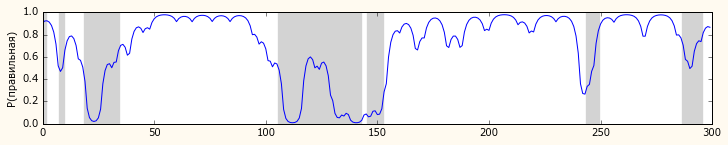

In [9]:
L = 300
Die, Rolls = Observation(A, E, L)
X = stationary_distribution(A)
Forward, P_x_f, m_f = Forward_algoritm(Rolls, A, E, X)
Backward, P_x_b, m_b = Backward_algoritm(Rolls, A, E, X)
Check_Forward_and_Backward_algorithms(P_x_f, P_x_b, m_f, m_b)
Aposterior = Aposterior_algorithm(Forward[0],Backward[0], P_x_f, m_f, m_b)
print_model_Aposterior(Aposterior, Die)

Изображение результатов алгоритма Витерби для последовательности длиной 1000  
L - длина последовательности  
Rolls - массив наблюдений  
По оси абсцисс - порядковый номер наблюдения  
По оси ординат - верояность состояния 0 (вероятность честной кости)  
Серым обозначены действительные моменты состояния 1 (нечестная кость)

Вероятности наблюдений алгоритмов равны: True


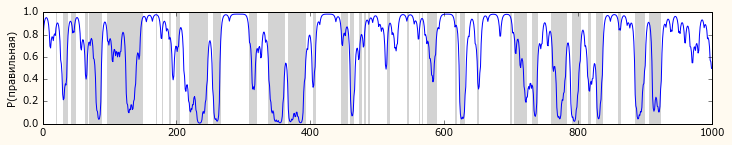

In [10]:
L = 1000
Die, Rolls = Observation(A, E, L)
X = stationary_distribution(A)
Forward, P_x_f, m_f = Forward_algoritm(Rolls, A, E, X)
Backward, P_x_b, m_b = Backward_algoritm(Rolls, A, E, X)
Check_Forward_and_Backward_algorithms(P_x_f, P_x_b, m_f, m_b)
Aposterior = Aposterior_algorithm(Forward[0],Backward[0], P_x_f, m_f, m_b)
print_model_Aposterior(Aposterior, Die)

**АЛГОРИТМ БАУМА-ВЕЛША**

In [11]:
# Функция нахождения суммы двух чисел в логарифмическом пространстве
# Входные параметры: логарфмы двух чисел
# Выходной параметр: логарифм суммы двух чисел
def logsum(x,y):
     return x + np.log(1 + np.exp(y-x))

# Функция нахождения суммы координат вектора в логарифмическом пространстве
# Входные параметры: логарфмы двух чисел
# Выходной параметр: логарифм суммы двух чисел
def logsum_n(vect):
    result = vect[0]
    for i in range(1,len(vect)):
        result = logsum(result, vect[i])
    return result

# Функция нормирования матриц по строкам (сумма по строке матрицы равна 1)
# Входные параметры: матрица
# Выходной параметр: нормированная по строкам матрица
def norm_matrix(x):
    return (x.transpose()/sum(x.transpose())).transpose()

# Функция создания п последовательностей наблюдей
# Входные параметры: число последовательностей, длина постедовательностей, матрица переходных вероятностей, матрица эмиссий 
# Выходной параметр: массив последовательностей наблюдений
def Rolls_create(n, L, A, E):
    Rolls_all = np.zeros(((n, L)), dtype=int)
    for i in range(n):
        Rolls_all[i] = Observation(A, E, L)[1]
    return Rolls_all

# Алгоритм Баума-Велша нахождения параметров задачи
# Входные параметры: массив последовательностей наблюдений, первоначальная матрица переходных вероятностей, 
# первоначальная матрица эмиссий, точность поиска (пороговое значение логарифма максимального правдоподобия)
# Выходной параметр: итоговая матрица переходных вероятностей, итоговая матрица эмиссийб время работы алгоритма, число итераций
def Baum_Welch(Rolls_all, A0, E0, eps):
    L = len(Rolls_all[0])
    M = len(E0)
    R = len(E0.transpose())
    n = len(Rolls_all)
    t = len(eps)
    start_time = time.time()
    time_all = np.zeros(t)
    iterations = np.zeros((t,), dtype = int)
    A_finished = []
    E_finished = []
    A_all = []
    E_all = []
    A_all.append(A0)
    E_all.append(E0)
    X = stationary_distribution(A0)
    i = 0
    q = 0
    while(1):
        resultA1 = np.zeros((M,M))
        resultE1 = np.zeros((M,R))
        Q = 0
        for j in range(n):
            resultA2 = np.zeros((M,M))
            resultE2 = np.zeros((M,R))
            Forward, P_x_1, m_f = Forward_algoritm(Rolls_all[j], A_all[i], E_all[i], X)
            Backward, P_x_2, m_b = Backward_algoritm(Rolls_all[j], A_all[i], E_all[i], X)
            log_P_x = np.log(P_x_1) + sum(np.log(m_f))
            for k in range(L-1):
                log_sum = (np.zeros((M,M)) + (np.log(Forward[:,k])).reshape(M,1) + sum(np.log(m_f[:k+1])) + np.log(A_all[i]) + 
                           + np.log(Backward[:,k+1]) + sum(np.log(m_b[k+1:])) + np.log(E_all[i][:, Rolls_all[j][k+1]-1]) - log_P_x)
                if k == 0:
                    resultA2 = log_sum
                else:
                    resultA2 = logsum(resultA2, log_sum)
            for k in range(L):
                log_sum = (np.log(Forward[:,k]) + sum(np.log(m_f[:k+1])) + np.log(Backward[:,k]) + sum(np.log(m_b[k:])) - log_P_x)
                if (resultE2[:, Rolls_all[j][k]-1] == np.zeros(M)).all():
                    resultE2[:, Rolls_all[j][k]-1] = log_sum                
                else:
                    resultE2[:, Rolls_all[j][k]-1] = logsum(resultE2[:, Rolls_all[j][k]-1], log_sum)
            
            if j == 0 :
                resultA1 = copy.deepcopy(resultA2)
                resultE1 = copy.deepcopy(resultE2)
            else:
                resultA1 = logsum(resultA1, resultA2)
                resultE1 = logsum(resultE1, resultE2)
        resultA1 = norm_matrix(np.exp(resultA1))
        X = stationary_distribution(resultA1)
        resultE1 = norm_matrix(np.exp(resultE1))
        A_all.append(np.array(resultA1))
        E_all.append(np.array(resultE1))
        if ((abs(np.log(A_all[-1]/A_all[-2])) < np.ones((M,M))*eps[q]).all() and 
            (abs(np.log(E_all[-1]/E_all[-2])) < np.ones((M,R))*eps[q]).all()):
            time_all[q] = (time.time()-start_time)/60
            iterations[q] = i + 1
            A_finished.append(A_all[-1])
            E_finished.append(E_all[-1])
            if q == t-1: 
                break
            q += 1
        i += 1
    return A_finished, E_finished, time_all, iterations

# Функция печати результатов алгоритма Баума-Велша
# Входные параметры: результаты алгоритма Baum_Welch
# Выходной параметр: иллюстрация результатов алгоритма Baum_Welch
def print_Baum_Welch(BW, eps):
    for i in range(len(eps)):  
        print('eps =', eps[i])
        print('A:', np.around(BW[0][i], decimals = 2), sep = '\n')
        print('E:', np.around(BW[1][i], decimals = 2), sep = '\n')
        print('Время выполнения (в минутах):', BW[2][i])
        print('Число итераций:', BW[3][i])
        print('')
    

Переменные, необходимые для реализации алгоритма Baum_Welch.  
А - матрица переходных вероятностей  
E - матрица эмиссий

In [12]:
A = np.array([[0.95,0.05],[0.1,0.9]])
E = np.array([[1/6,1/6,1/6,1/6,1/6,1/6],[0.1,0.1,0.1,0.1,0.1,0.5]])
print('A:', A, 'E:', E, sep = '\n')

A:
[[ 0.95  0.05]
 [ 0.1   0.9 ]]
E:
[[ 0.16666667  0.16666667  0.16666667  0.16666667  0.16666667  0.16666667]
 [ 0.1         0.1         0.1         0.1         0.1         0.5       ]]


Задание первоначальных матрицы переходных вероятностей и матрицы эмиссий

In [13]:
M = len(E)
R = len(E.transpose())
while(1):
    A0 = np.around(norm_matrix(np.random.random((M,M))), decimals = 2)
    E0 = np.around(norm_matrix(np.random.random((M,R))), decimals = 2)
    if (A0 != np.zeros((M,M))).all() and (E0 != np.zeros((M,R))).all():
        print('A0:', A0, 'E0:', E0, sep = '\n')
        break

A0:
[[ 0.51  0.49]
 [ 0.48  0.52]]
E0:
[[ 0.13  0.25  0.32  0.08  0.07  0.14]
 [ 0.06  0.24  0.26  0.01  0.08  0.35]]


Нахождение параметров задачи с помощью алогритма Baum_Welch с различными параметрами окончания (порогого значения изменения логарифма правдоподобия)

Алгоритм Baum_Welch для 20 обучающих последовательностей длинной 300

In [14]:
n = 20
L = 300
eps = np.array([1.e-1,1.e-2,1.e-3, 1.e-4])
Rolls_all = Rolls_create(n, L, A, E)
BW = Baum_Welch(Rolls_all, A0, E0, eps)
print_Baum_Welch(BW, eps)

eps = 0.1
A:
[[ 0.55  0.45]
 [ 0.5   0.5 ]]
E:
[[ 0.19  0.14  0.15  0.25  0.13  0.15]
 [ 0.1   0.15  0.14  0.03  0.17  0.42]]
Время выполнения (в минутах): 0.149550112089
Число итераций: 2

eps = 0.01
A:
[[ 0.95  0.05]
 [ 0.12  0.88]]
E:
[[ 0.17  0.15  0.17  0.17  0.17  0.17]
 [ 0.08  0.11  0.08  0.08  0.1   0.55]]
Время выполнения (в минутах): 6.91952950954
Число итераций: 100

eps = 0.001
A:
[[ 0.96  0.04]
 [ 0.11  0.89]]
E:
[[ 0.17  0.15  0.17  0.17  0.17  0.17]
 [ 0.08  0.11  0.08  0.08  0.1   0.55]]
Время выполнения (в минутах): 8.78526875575
Число итераций: 127

eps = 0.0001
A:
[[ 0.96  0.04]
 [ 0.11  0.89]]
E:
[[ 0.17  0.15  0.17  0.17  0.17  0.17]
 [ 0.08  0.11  0.08  0.08  0.1   0.55]]
Время выполнения (в минутах): 10.5124222596
Число итераций: 152



Алгоритм Baum_Welch для 10 обучающих последовательностей длинной 1000

In [15]:
n = 10
L = 1000
eps = np.array([1.e-1,1.e-2,1.e-3])
Rolls_all = Rolls_create(n, L, A, E)
BW = Baum_Welch(Rolls_all, A0, E0, eps)
print_Baum_Welch(BW, eps)

eps = 0.1
A:
[[ 0.55  0.45]
 [ 0.5   0.5 ]]
E:
[[ 0.19  0.14  0.15  0.25  0.13  0.14]
 [ 0.1   0.15  0.14  0.03  0.16  0.42]]
Время выполнения (в минутах): 0.404869544506
Число итераций: 2

eps = 0.01
A:
[[ 0.55  0.45]
 [ 0.5   0.5 ]]
E:
[[ 0.19  0.14  0.15  0.25  0.13  0.14]
 [ 0.1   0.15  0.14  0.03  0.16  0.42]]
Время выполнения (в минутах): 0.607627654076
Число итераций: 3

eps = 0.001
A:
[[ 0.96  0.04]
 [ 0.1   0.9 ]]
E:
[[ 0.17  0.16  0.16  0.16  0.16  0.18]
 [ 0.1   0.09  0.09  0.11  0.1   0.51]]
Время выполнения (в минутах): 38.3586508115
Число итераций: 190



Алгоритм Baum_Welch для 1 обучающей последовательности длинной 10000

In [16]:
n = 1
L = 10000
eps = np.array([1.e-1,1.e-2,1.e-3])
Rolls_all = Rolls_create(n, L, A, E)
BW = Baum_Welch(Rolls_all, A0, E0, eps)
print_Baum_Welch(BW, eps)

eps = 0.1
A:
[[ 0.54  0.46]
 [ 0.5   0.5 ]]
E:
[[ 0.19  0.15  0.15  0.23  0.13  0.15]
 [ 0.1   0.16  0.14  0.03  0.16  0.41]]
Время выполнения (в минутах): 2.62790029049
Число итераций: 2

eps = 0.01
A:
[[ 0.55  0.45]
 [ 0.49  0.51]]
E:
[[ 0.19  0.15  0.15  0.23  0.13  0.14]
 [ 0.1   0.16  0.14  0.03  0.16  0.41]]
Время выполнения (в минутах): 3.94179808299
Число итераций: 3

eps = 0.001
A:
[[ 0.95  0.05]
 [ 0.1   0.9 ]]
E:
[[ 0.16  0.18  0.17  0.16  0.17  0.16]
 [ 0.11  0.11  0.1   0.1   0.09  0.49]]
Время выполнения (в минутах): 196.885754569
Число итераций: 150



Анализ алгоритма Baum_Welch показал, что в текущей реализации, результат (опеределененный в задаче) определяется с   достаточной точность при изменении логарифма правдоподобия на 0.001.

**ПРОВЕРКА АЛГОРИТМОВ ВИТЕРБИ И АПОСТЕРИОРНОГО ДЕШИФРОВАНИЯ ПО ПРИМЕРАМ ИЗ УЧЕБНИКА**

In [17]:
Rolls_str = ('3151162464466442453113216311641521336251445436316566265666666511664531326512456366646316366631623264552362666666' +
             '2515163122255544166656656356432436413151346514635341112641462625335636616366636623253551366166116325256246225526' + 
             '5252266435353336233121625364414432335163243633665562466662632666612355245242')
Die_str = ('000000000000000000000000000000000000000000000111111111111111111111000000000000111111111111111100011111111111111000' +
           '000000000000001111111111111000000000000000000000000000000000000011111111110000000000000000000000000000000000000000' +
           '000000000000000000000000000000000000000111111111111111111111100000000000')
A = np.array([[0.95,0.05],[0.1,0.9]])
E = np.array([[1/6,1/6,1/6,1/6,1/6,1/6],[0.1,0.1,0.1,0.1,0.1,0.5]])
L = len(Rolls_str)
Rolls = np.zeros((L,), dtype=int)
Die = np.zeros((L,), dtype=int)
for i in range(L):
    Rolls[i] = Rolls_str.split()[0][i]
    Die[i] = Die_str.split()[0][i]
Viterby = Algorithm_Viterby(Rolls, A, E)
print_model_Viterby(Die, Rolls, Viterby, 60)

Rolls:   315116246446644245311321631164152133625144543631656626566666
Die:     FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFLLLLLLLLLLLLLLL
Viterby: FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFLLLLLLLLLLLL 

Rolls:   651166453132651245636664631636663162326455236266666625151631
Die:     LLLLLLFFFFFFFFFFFFLLLLLLLLLLLLLLLLFFFLLLLLLLLLLLLLLFFFFFFFFF
Viterby: LLLLLLFFFFFFFFFFFFLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLFFFFFFFF 

Rolls:   222555441666566563564324364131513465146353411126414626253356
Die:     FFFFFFFFLLLLLLLLLLLLLFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFLL
Viterby: FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFL 

Rolls:   366163666366232535513661661163252562462255265252266435353336
Die:     LLLLLLLLFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF
Viterby: LLLLLLLLLLLLFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF 

Rolls:   233121625364414432335163243633665562466662632666612355245242
Die:     FFFFFFFFFFFFFFFFFFFFFFFFFFFLLLLLLLLLLLLLLLLLLLLLLFFFFFFFFFFF
Viterby: FFF

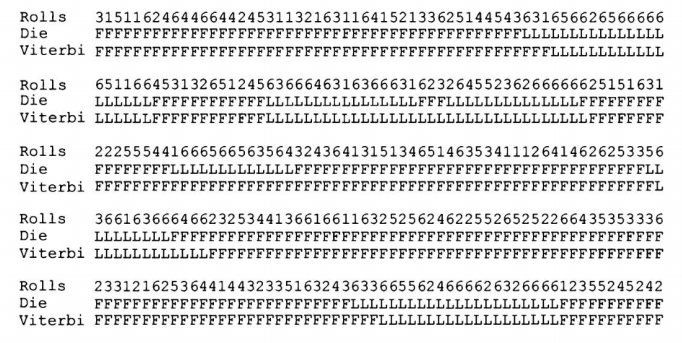

In [18]:
Image(filename= r'C:\Viterby.png')

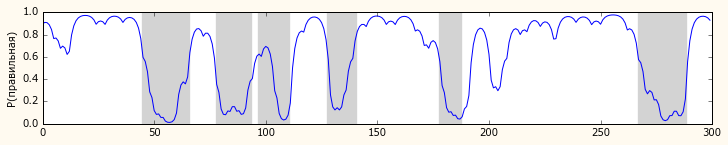

In [19]:
A = np.array([[0.95,0.05],[0.1,0.9]])
E = np.array([[1/6,1/6,1/6,1/6,1/6,1/6],[0.1,0.1,0.1,0.1,0.1,0.5]])
X = stationary_distribution(A)
Forward, P_x_f, m_f = Forward_algoritm(Rolls, A, E, X)
Backward, P_x_b, m_b = Backward_algoritm(Rolls, A, E, X)
Aposterior = Aposterior_algorithm(Forward[0],Backward[0],P_x_f, m_f, m_b)
print_model_Aposterior(Aposterior, Die)

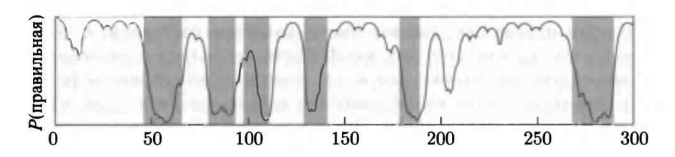

In [20]:
Image(filename= r'C:\Aposterior.png')